# 机器学习实验五   --聚类层次

> 朱浩泽 计算机科学与技术 1911530

## 实验要求
- 数据集 <br/>
生成 2000 个样例，每个样例的前 3 列表示特征，第 4 列表示标签
- 基本要求
    - 绘制聚类前后样本分布情况
    - 实现 single-linkage 层次聚类算法
    - 实现 complete-linkage 层次聚类算法
<br/>
- 中级要求 <br/>
实现 average-linkage 层次聚类算法，绘制样本分布图
<br/>
- 提高要求<br/>
对比上述三种算法，给出结论。
## 生成数据
数据: 生成包含 N=2000 个三维随机矢量的数据集合，数据集合中随机矢量来自于三个分布模型，分别满足均值矢量 $m1 = [1,1,1]^T$,$m2 = [4,4,4]^T$, $m3 = [8,1,1]^T $和协方差矩阵$S_1 =S_2 =S_3 =I$，其中I是3×3的单位矩阵。在生成数据集合X时，假设来自三个分布模型的先验概率相同 $p(w1) = p(w2) = p(w3) = 1/3$
利用numpy包下的random.multivariate_normal函数进行生成，代码如下

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def random_x(cnt1, cnt2, cnt3, name): 
    cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    a1 = np.random.multivariate_normal((1, 1 ,1), cov, cnt1) #满足均值矢量
    a2 = np.random.multivariate_normal((4, 4 ,4), cov, cnt2)
    a3 = np.random.multivariate_normal((8, 1 ,1), cov, cnt3)
    colors0 = '#000000'
    colors1 = '#00CED1' #点的颜色
    colors2 = '#DC143C'
    area = np.pi   # 点面积
    fig = plt.figure()
    ax = Axes3D(fig)
    x = a1[:, 0]
    y = a1[:, 1] 
    z = a1[:, 2]
    ax.scatter(x, y, z, c = colors0, s = area)
    x = a2[:, 0]
    y = a2[:, 1] 
    z = a2[:, 2]
    ax.scatter(x, y, z, c = colors1, s = area)
    x = a3[:, 0]
    y = a3[:, 1] 
    z = a3[:, 2]
    ax.scatter(x, y, z, c = colors2, s = area)

    ls = []
    result = []
    for i in range(cnt1):
        ls.append(a1[i])
        result.append(1)
    for i in range(cnt2):
        ls.append(a2[i])
        result.append(2)
    for i in range(cnt3):
        ls.append(a3[i])
        result.append(3)
    plt.figure(num = name) 
    return ls, result

## 实现 single-linkage 层次聚类算法
最短距离 / 单连接 (single linkage):类 Gp 的样本与 Gq 的样本之间的最短距离<br/>
$D_{pq} = min\{d_{ij}|x_i \in G_p, x_j \in G_q\}$

In [59]:
def single_linkage(kind1, kind2, data):
    min = float("inf")
    for i in range(len(kind1)):
        for j in range(len(kind2)):
            t = np.linalg.norm(data[kind1[i]] - data[kind2[j]])
            if t < min:
                min = t
    return min

## 实现complete-linkage 层次聚类算法
最⻓距离 / 全连接 (complete linkage): 类 Gp 的样本与 Gq 样本之间的最⻓距离<br/>
$D_{pq} = max\{d_{ij}|x_i \in G_p, x_j \in G_q\}$

In [47]:
def complete_linkage(kind1, kind2, data):
    max = float("-inf")
    for i in range(len(kind1)):
        for j in range(len(kind2)):
            t = np.linalg.norm(data[kind1[i]] - data[kind2[j]])
            if t > max:
                max = t
    return max

## 实现 average-linkage 层次聚类算法
平均距离 (average linkage): 类 Gp 与 Gq 任意两个样本之间距离的平均值<br/>
$D_{pq} = \frac{1}{n_pn_q}\sum_{x_i \in G_p}\sum_{x_j \in G_q} d_{ij}$

In [48]:
def average_linkage(kind1, kind2, data):
    avg = 0.0
    for i in range(len(kind1)):
        for j in range(len(kind2)):
            avg += np.linalg.norm(data[kind1[i]] - data[kind2[j]]) 
    return avg / (len(kind1) * len(kind2))

## 实现聚类
- 首先计算每个点之间的距离存入矩阵

In [5]:
def distance(data):
    ls = [ [] for i in range(len(data))]
    for i in range(len(data)):
        for j in range(len(data)):
            if i >= j:
                ls[i].append(float("inf"))
            else:
                ls[i].append(np.linalg.norm(data[i] - data[j]))
    return ls   

- 聚类实现思路
    - 维护一个数据结构，为list类型，其中每个元素也为一个list类型。子list中包含的一个聚类的点的集合，父list包含的是一个个聚类，最终等父list只剩下三个聚类时停止操作。
    - 在更新距离矩阵的时候，只需要更新改动的两行，将归入的聚类行删除，更改其之其他聚类之间的距离。
- 迭代计算聚类
    - data代表原始数据
    - dis表示距离矩阵
    - func表示的是聚类方法
        1. single_linkage
        2. complete_linkage
        3. average_linkage
    - num是要分成的类别数量

In [60]:
def Clustering(data, dis, func, num = 3):
    category = []
    for i in range(len(data)):
         temp = []
         temp.append(i)
         category.append(temp)
    while len(category) > num:
         t = np.asarray(dis)
         w = t.shape[1]
         position = t.argmin()                         
         row, col = position // w, position % w  #找到矩阵中的最小值
         #更改分类中的内容
         if row > col:
              temp = category.pop(row)
              temp = temp + category[col]
              category[col] = temp
         else:
              temp = category.pop(col)
              temp = temp + category[row]
              category[row] = temp
         if func == 0:
              if row > col:
                   dis.pop(row)
                   for i in range(len(dis)):
                         dis[i].pop(row)
                   for i in range(col + 1, len(dis)):
                         dis[col][i] = single_linkage(category[col], category[i], data)
                   for i in range(0, col - 1):
                         dis[i][col] = single_linkage(category[col], category[i], data)
              else:
                   dis.pop(col)
                   for i in range(len(dis)):
                         dis[i].pop(col)
                   for i in range(row + 1, len(dis)):
                         dis[row][i] = single_linkage(category[row], category[i], data)
                   for i in range(0, row - 1):
                         dis[i][row] = single_linkage(category[row], category[i], data)
         elif func == 1:
              if row > col:
                   dis.pop(row)
                   for i in range(len(dis)):
                         dis[i].pop(row)
                   for i in range(col + 1, len(dis)):
                         dis[col][i] = complete_linkage(category[col], category[i], data)
                   for i in range(0, col - 1):
                         dis[i][col] = complete_linkage(category[col], category[i], data)
              else:
                   dis.pop(col)
                   for i in range(len(dis)):
                         dis[i].pop(col)
                   for i in range(row + 1, len(dis)):
                         dis[row][i] = complete_linkage(category[row], category[i], data)
                   for i in range(0, row - 1):
                         dis[i][row] = complete_linkage(category[row], category[i], data)
         elif func == 2:
              if row > col:
                   dis.pop(row)
                   for i in range(len(dis)):
                         dis[i].pop(row)
                   for i in range(col + 1, len(dis)):
                         dis[col][i] = average_linkage(category[col], category[i], data)
                   for i in range(0, col - 1):
                         dis[i][col] = average_linkage(category[col], category[i], data)
              else:
                   dis.pop(col)
                   for i in range(len(dis)):
                         dis[i].pop(col)
                   for i in range(row + 1, len(dis)):
                         dis[row][i] = average_linkage(category[row], category[i], data)
                   for i in range(0, row - 1):
                         dis[i][row] = average_linkage(category[row], category[i], data)
    return category
                  

## 展示数据
将分好的类以散点图的形式画出

In [35]:
def show(result, data):
    x = [[] for i in range(len(result))]
    y = [[] for i in range(len(result))]
    z = [[] for i in range(len(result))]
    for i in range(len(result)):
        for j in range(len(result[i])):
            x[i].append(data[result[i][j]][0])
            y[i].append(data[result[i][j]][1])
            z[i].append(data[result[i][j]][2])
    colors0 = '#000000'
    colors1 = '#00CED1' #点的颜色
    colors2 = '#DC143C'
    area = np.pi   # 点面积
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x[0], y[0], z[0], c = colors0, s = area)
    ax.scatter(x[1], y[1], z[1], c = colors1, s = area)
    ax.scatter(x[2], y[2], z[2], c = colors2, s = area)


## 进行带数据的测试
- 实现signle_linkage层次聚类算法（上图为原始数据的聚类，下图为利用算法计算出的聚类的分布）

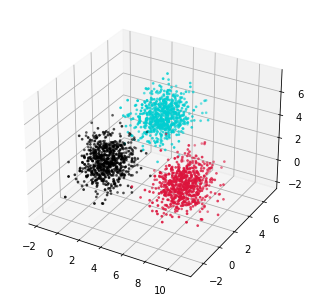

<Figure size 432x288 with 0 Axes>

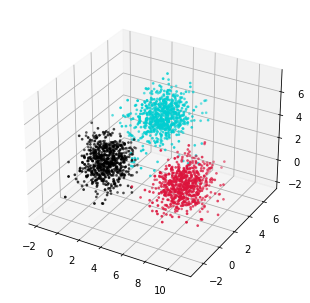

In [66]:
data2, k2 = random_x(666, 667, 667, "散点图")
dis2 = distance(data2)
result2 = Clustering(data2, dis2, 0)
show(result2, data2)

- 实现complete_linkage层次聚类算法（上图为原始数据的聚类，下图为利用算法计算出的聚类的分布）

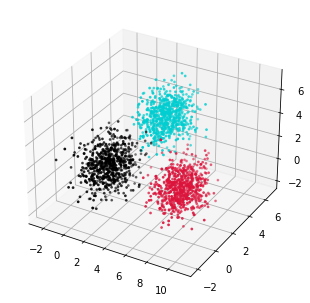

<Figure size 432x288 with 0 Axes>

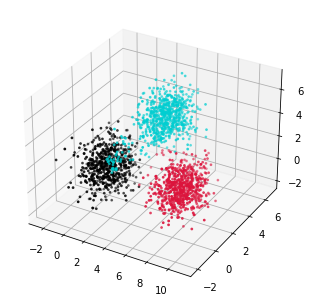

In [51]:
data3, k3 = random_x(666, 667, 667, "散点图")
dis3 = distance(data3)
result3 = Clustering(data3, dis3, 1)
show(result3, data3)


- 实现 average-linkage 层次聚类算法（上图为原始数据的聚类，下图为利用算法计算出的聚类的分布）

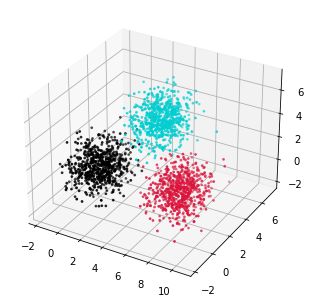

<Figure size 432x288 with 0 Axes>

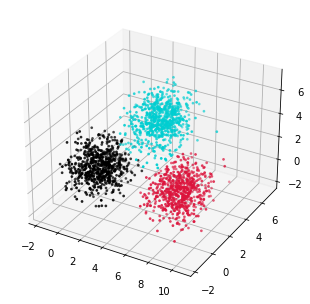

In [44]:
data1, k1 = random_x(666, 667, 667, "散点图")
dis1 = distance(data1)
result1 = Clustering(data1, dis1, 2)
show(result1, data1)

## 实验结果对比分析
通过上述实验，我们可以明显的看出，使用average-linkage算法的实验结果明显优于使用signle-linkage和complete-linkage算法的实验结果。signle-linkage和complete-linkage算法在处理边缘和交界处的数据时表现不够好，甚至导致了黑色数据内部出现了可以观测的蓝色。通过分析三种算法，可以得出结论：<br/>
- SingleLinkage容易造成两个聚类明明从“大局”上离得比较远，但是由于其中个别的点距离比较近就被合并了，并且这样合并之后这种情况会进一步扩大，最后会得到比较松散的聚类 。
- CompleteLinkage会导致两个 cluster 即使已经很接近了，但是只要有不配合的点存在，就不会合并。这两种相似度的定义方法的共同问题就是指考虑了某个有特点的数据，而没有考虑类内数据的整体特点。
- Average-linkage：这种方法就是把两个集合中的点两两的距离全部放在一起求一个平均值，相对也能得到合适一点的结果。考虑了整体情况，不会因为某些极端值或边界上的点影响整体结果。